<a href="https://colab.research.google.com/github/vlimax/Aprenda-IA-Generativa-Com-Google-Colab/blob/Embedding/02_Embeddings_e_Vetorizacao/Embeddings_Google_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.0 Um Pouco Sobre Embeddings
Computadores entendem a lógica booleana e trabalham manipulando entidades numéricas. Logo, para processarem a linguagem natural (NLP), é preciso transformá-la em uma representação numérica que possa carregar as propriedades semânticas (de significado) presentes em nossa comunicação.

Por isso, ao lidar com textos, imagens e sons, desenvolveram-se muitos métodos, entre eles temos os chamados de "Embedding" (como o Word2Vec), que literalmente significa incorporação ou embutimento.

Na prática, vamos embutir um conceito, ideia ou dado num espaço matemático (aí vêm duas perguntas: na matemática, o que é algo no espaço e por que pensar em espaço?).

Pensamos em "espaço" por um motivo fundamental: as relações de geometria nos permite pensar em distâncias. Se transformarmos palavras em coordenadas espaciais, conceitos com significados semelhantes (como "Rei" e "Rainha") terão vetores geometricamente próximos. Conceitos não relacionados estarão distantes. Ao atribuir coordenadas, criamos essencialmente um vetor; por isso, os métodos de embedding também são chamados de vetorização. Assim, é possível estabelecer comparações semânticas entre palavras por métodos matemátios como distância euclidiana, similaridade de cosseno, etc.

Além dessa abordagem espacial, existem algoritmos mais antigos que lidam com textos, como os que fazem a contagem da presença de uma palavra num documento e atribuem uma importância a ela (o TF-IDF), ainda muito comuns em motores de busca. Mas medir a importância de uma palavra no texto não está necessariamente capturando suas propriedades semânticas.

Para mais informações, consulte:

- **Guia de Embeddings Gemini:** https://ai.google.dev/gemini-api/docs/embeddings

1.1 Como Processar Dados Para Embedding.

Primeiramente, assim como nos modelos de LLM a unidade mínima de processamento de texto é o **token**, na vetorização de documentos introduzimos o **chunk** (fragmento ou pedaço) como uma unidade de significado. Enquanto o **token** é a "peça" atômica que a máquina lê, o **chunk** é o bloco de texto (uma frase, parágrafo ou seção) que escolhemos para **representar uma ideia completa no espaço vetorial**. Portanto, ainda estamos trabalhando com **tokens**, mas o conjunto de **tokens** que formam um contexto específico é o que chamamos de **chunk**.

Dessa maneira, um documento grande como um livro, é subdivido em chunks, e essa divisão se torna muito importante por esses dois motivos fundamentais:

- **Limite técnico:** As APIs possuem um limite máximo de tokens que conseguem processar e vetorizar por requisição.

- **Foco semântico:** Um documento longo aborda múltiplos assuntos e nuances. Se você vetorizá-lo por completo de uma só vez, os significados matemáticos se diluem e se misturam (da mesma forma o contexto pode se perder se você fizer muitas subdivisões de chunks), gerando um vetor "genérico" e impreciso. Ao dividir em chunks (como parágrafos ou seções), cada vetor carrega um significado forte e altamente específico, o que torna a busca muito mais exata.

Por fim, você pode pensar em vetorizar um dado para diferentes fins:

Task (Ação) | Descrição | Exemplo
---|---|---
**RETRIEVAL_QUERY** (Fazer busca) | Pergunta curta otimizada para atuar como termo de busca. | "Como calcular a concorrência?"
**RETRIEVAL_DOCUMENT** (Guardar no banco) | Texto para o banco de dados, otimizado para ser encontrado pela Query. | Trecho de um edital em PDF.
**SEMANTIC_SIMILARITY** (Comparar) | Mede a distância entre frases para checar se significam a mesma coisa. | Avaliar paráfrases ou achar textos duplicados.
**CLASSIFICATION** (Classificar) | Prepara o vetor para algoritmos de aprendizado supervisionado. | Prever diagnóstico de diabetes a partir de laudos.
**CLUSTERING** (Agrupar) | Prepara vetores para algoritmos não supervisionados, agrupando assuntos semelhantes. | Agrupar estudos sobre ilhas de calor urbano.

## 2.0 Baixa e importa o SDK python e bibliotecas.

In [1]:
!pip install -q -U google-generativeai

import google.generativeai as genai
from google.colab import userdata

/usr/local/lib/python3.12/dist-packages/google/colab/_import_hooks/_hook_injector.py:55: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  loader.exec_module(module)


## 3.0 Configura a chave

In [2]:
user_key = userdata.get("GEMINI_API_KEY")

genai.configure(api_key=user_key)

## 4.0 Fazer vetorização

Para listar os modelos disponíveis, executamos o código abaixo. O laço `for` percorre uma lista de modelos retornados por `genai.list_models()`. Em cada repetição, a estrutura `if` verifica se aquele modelo possui a capacidade `embedContent` (fazer o embedding) em sua lista de capacidades (`supported_generation_methods`). Se o modelo for compatível com a criação de embeddings, seu nome é exibido no terminal.

Para informações técnicas dos modelos embedding: [Modelos](https://ai.google.dev/gemini-api/docs/embeddings#model-versions)

É importante conferir o link acima para saber quantos tokens e quais tipos de dados eles suportam como input.

In [3]:
for m in genai.list_models():
    if 'embedContent' in m.supported_generation_methods:
        print(m.name)

models/gemini-embedding-001


Após escolher o modelo, utilizamos o `método embed_content()` para realizar a vetorização. Este método exige que você especifique três pilares fundamentais: **o modelo de embedding** desejado, **o conteúdo (apenas do tipo string)** que será transformado em números e, o mais importante, **o tipo de tarefa (task_type)**. Definir a tarefa ajuda o modelo a otimizar o vetor para um objetivo específico, como uma busca ou uma classificação.

In [4]:
result = genai.embed_content(
    model="models/gemini-embedding-001",
    content="Como calcular a concorrência de uma prova?",
    task_type="retrieval_query"
)

# Você enviou 1 input para embedding, então gerou 1 output como vetor.
print("Frase vetorizada: ", str(result["embedding"])[:50], "... TRIMMED]")

Frase vetorizada:  [0.0052197427, 0.007644003, 0.04510661, -0.0542397 ... TRIMMED]


**Obs:** A task `retrivial_document` exige um **título para funcionar como uma "âncora contextual" para os seus chunks**. Imagine que você dividiu um Código de Conduta da empresa em 50 parágrafos; ao atribuir o mesmo título a todos eles, você garante que o algoritmo entenda que todos pertencem ao mesmo documento, evitando que esses vetores fiquem "órfãos" ou percam parte do contexto original quando armazenados no banco de dados.

Você também pode passar uma lista de strings como input, lembrando sempre do limite de tokens que o modelo suporta, mas não se preocupe, o limite especificado aplica-se a cada item individual da sua lista, e não à soma de todos eles.

In [5]:
result = genai.embed_content(
    model = "models/gemini-embedding-001",
    content = [
        "O tomate, apesar de ser usado em saladas, é botanicamente uma fruta.",
        "A maçã possui uma polpa crocante e é rica em fibras.",
        "A banana é uma das frutas mais consumidas no Brasil e nasce em cachos.",
    ],
    task_type = "retrieval_document",
    title = "Enciclopédia de Frutas" # Este título ancora o contexto de todos os itens acima
)

# Você enviou uma lista como input para fazer o embedding, então gerou uma lista de vetores como output, por isso iterar com for.
print("Frases vetorizadas:")
for v in result["embedding"]:
    print(str(v)[:50], "... TRIMMED ...")

Frases vetorizadas:
[-0.0013930693, 0.015898436, 0.008572805, -0.05027 ... TRIMMED ...
[-0.009155744, 0.025684193, 0.0148765445, -0.03721 ... TRIMMED ...
[-0.012072629, 0.005662022, -0.00047756982, -0.046 ... TRIMMED ...


Até agora usamos só strings para vetorizar, mas e se eu quiser vetorizar imagens ou aúdio? Aqui entramos em uma limitação desse modelo específico do google (mas ele possui outros que não tem essa limitação, acessíveis em outros ambientes de desenvolvimento). O `gemini-embedding-001` apesar de ter sido treinado com uma ampla quantidade de dados se comparado com suas versões anteriores, **só tem suporte para vetorização de texto**, embora a forma que ele empacota os dados seja do mesmo tipo de objeto que os modelos generativos (o que abre possibilidade para no futuro ele vetorizar diretamente outros tipos de dados além de texto e se tornar multimodal).

Assim, caso o usuário quiser vetorizar imagens, músicas, entre outros tipos de dados com modelos que ainda não são multimoldais, você deve primeiro processá-los para texto (com `generate_content()`), pegar a resposta e fazer embedding (com `embedding_content()`.


Processando uma resposta específica:

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  201k  100  201k    0     0   123k      0  0:00:01  0:00:01 --:--:--  123k


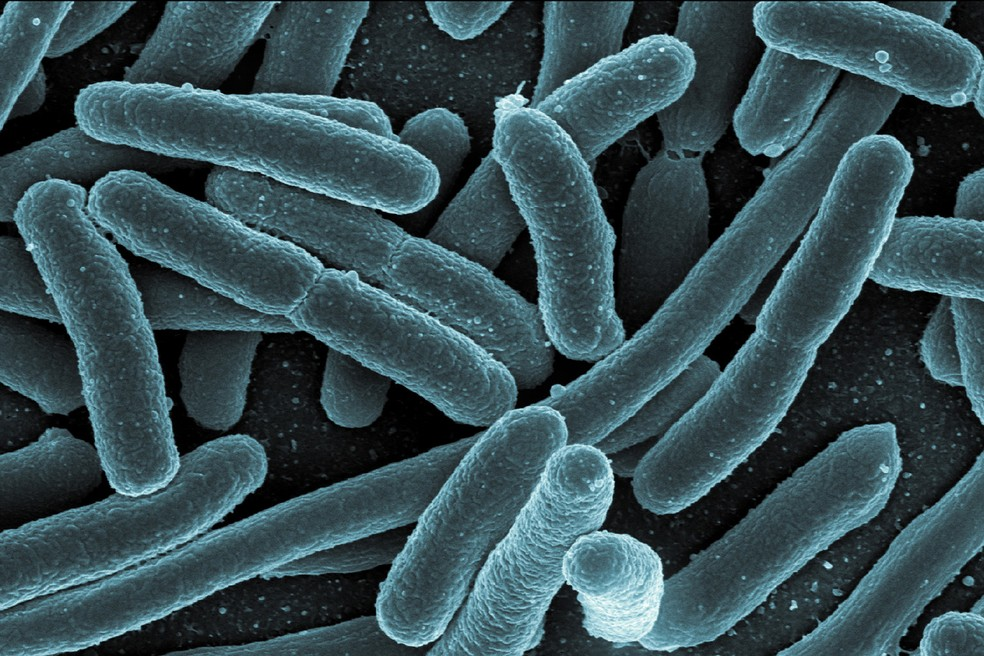

In [18]:
#Baixando imagem
!curl -o image.jpg "https://s2-g1.glbimg.com/CX2CcKpQ57rcIID3FrXZHSE7OpI=/0x0:1280x853/984x0/smart/filters:strip_icc()/s3.glbimg.com/v1/AUTH_59edd422c0c84a879bd37670ae4f538a/photos/apis/d707db0468ed4d98a28cb31908a969d2/ecoli-blue.jpg"

import PIL.Image
#importa imagem
img = PIL.Image.open("image.jpg")

img


In [19]:
#Escolhe modelo generativo
model = genai.GenerativeModel("gemini-2.5-flash")

In [20]:
#Gera uma descrição da imagem
descricao_imagem = model.generate_content(
    ["Descreva essa imagem nos mínimos detalhes, sem formatação visual, texto puro.",
     img]
    )

In [21]:
#Visualizar a resposta
descricao_imagem.text

'A imagem é uma fotografia de alta resolução, provavelmente obtida por microscopia eletrônica de varredura (SEM), que exibe um campo denso de micro-organismos em forma de bastonete (bacilos).\n\nOs micro-organismos são predominantemente de cor ciano ou azul-esverdeado, contrastando com um fundo escuro, quase preto, com uma textura granular sutil. Eles preenchem quase todo o quadro, dispostos em várias orientações e frequentemente se sobrepondo uns aos outros. As formas são cilíndricas ou alongadas, com extremidades arredondadas, variando ligeiramente em comprimento, mas com largura relativamente consistente.\n\nA característica mais proeminente da sua superfície é a textura áspera, granular e irregular, que confere uma aparência rugosa e não lisa a cada bastonete. A iluminação da imagem realça a sua tridimensionalidade, com áreas mais claras (quase esbranquiçadas ou azul-claras) nas partes superiores e laterais que recebem mais luz, e áreas mais escuras (azul-acinzentadas) nas regiões 

In [22]:
#Visualizar como a resposta ficou armazenada no pacote.
descricao_imagem.candidates[0].content

parts {
  text: "A imagem é uma fotografia de alta resolução, provavelmente obtida por microscopia eletrônica de varredura (SEM), que exibe um campo denso de micro-organismos em forma de bastonete (bacilos).\n\nOs micro-organismos são predominantemente de cor ciano ou azul-esverdeado, contrastando com um fundo escuro, quase preto, com uma textura granular sutil. Eles preenchem quase todo o quadro, dispostos em várias orientações e frequentemente se sobrepondo uns aos outros. As formas são cilíndricas ou alongadas, com extremidades arredondadas, variando ligeiramente em comprimento, mas com largura relativamente consistente.\n\nA característica mais proeminente da sua superfície é a textura áspera, granular e irregular, que confere uma aparência rugosa e não lisa a cada bastonete. A iluminação da imagem realça a sua tridimensionalidade, com áreas mais claras (quase esbranquiçadas ou azul-claras) nas partes superiores e laterais que recebem mais luz, e áreas mais escuras (azul-acinzentad

In [23]:
#Vetorizar a descrição
descricao_vetorizada = genai.embed_content(
    model = "models/gemini-embedding-001",
    content = descricao_imagem.candidates[0].content
)

# Exibir o vetor
print("Descrição vetorizada da imagem: ", str(descricao_vetorizada["embedding"])[:50], "... TRIMMED ...")

Descrição vetorizada da imagem:  [-0.0049585523, -0.0014245915, -0.008074105, -0.07 ... TRIMMED ...


Processando o histórico do chat: